## Setup

In [1]:
# Libraries
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from waveome import regularization, utilities, kernels

f64 = gpflow.utilities.to_default_float

## Simulation Example

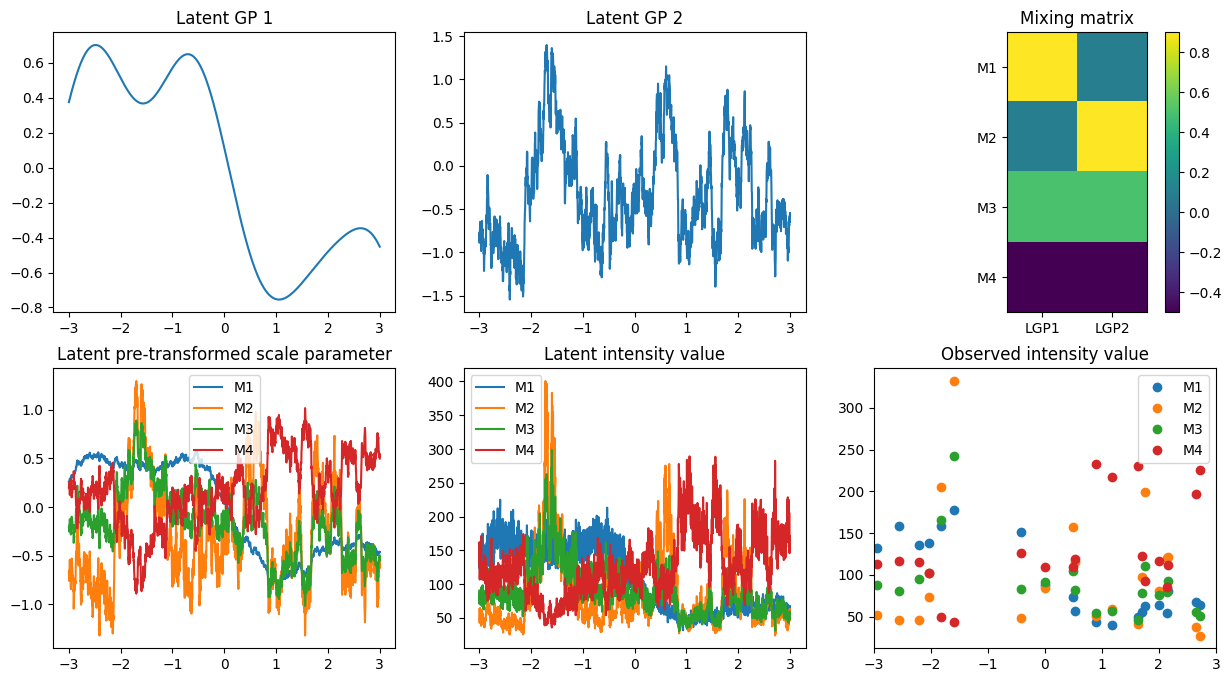

In [73]:
# Set up kernels
k1 = gpflow.kernels.SquaredExponential()
k2 = gpflow.kernels.Matern12(variance=1., lengthscales=0.5)

# Mixing matrix
w_matrix = np.array([[0.9, 0.1],[0.1, 0.9],[.5, .5], [-.5, -.5]])
# w_matrix = np.array([[9, 1],[1, 9],[5, 5], [-5, -5]])


# Input points
x_grid = np.linspace(start=-3, stop=3, num=2000).reshape(-1, 1)
n_obs = 20

# Inference in latent space
np.random.seed(9102)
lrv1 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=k1.K(x_grid),
    size=1
).T
# Just make sin function for now
# lrv1 = np.sin(x_grid).reshape(-1, 1)

lrv2 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=k2.K(x_grid),
    size=1
).T

# Now mix inputs to make outputs
y_out = (w_matrix @ np.concatenate((lrv1, lrv2), axis=1).T).T

figs, axs = plt.subplots(2, 3, figsize=(15, 8))
axs[0, 0].plot(x_grid, lrv1)
axs[0, 0].set_title("Latent GP 1")
axs[0, 1].plot(x_grid, lrv2)
axs[0, 1].set_title("Latent GP 2")
axs[0, 2].imshow(w_matrix)
axs[0, 2].set_title("Mixing matrix")
axs[0, 2].set_yticks([0, 1, 2, 3])
axs[0, 2].set_yticklabels(["M1", "M2", "M3", "M4"])
axs[0, 2].set_xticks([0, 1])
axs[0, 2].set_xticklabels(["LGP1", "LGP2"])
plt.colorbar(axs[0, 2].imshow(w_matrix), ax=axs[0, 2])

# Now plot the combined GPs
axs[1, 0].plot(x_grid, y_out, label=["M1", "M2", "M3", "M4"])
axs[1, 0].set_title("Latent pre-transformed scale parameter")
axs[1, 0].legend()
obs_out = np.random.gamma(shape=100., scale=np.exp(y_out))
axs[1, 1].plot(x_grid, obs_out, label=["M1", "M2", "M3", "M4"])
axs[1, 1].set_title("Latent intensity value")
axs[1, 1].legend()

# Subset observations
sub_idx = np.random.choice(a=range(len(x_grid)), size=n_obs, replace=False)
axs[1, 2].plot(x_grid[sub_idx], obs_out[sub_idx,:], 'o', label=["M1", "M2", "M3", "M4"])
axs[1, 2].set_xlim((-3, 3))
axs[1, 2].legend()
axs[1, 2].set_title("Observed intensity value")
plt.show()


In [3]:
# Now try to recover the latent kernels
X = x_grid[sub_idx]
Y = obs_out[sub_idx, :]

# Fit multioutput model
m = gpflow.models.SVGP(
    kernel=gpflow.kernels.LinearCoregionalization(
        kernels=[gpflow.kernels.SquaredExponential(), gpflow.kernels.Matern12()],
    W=np.random.normal(size=(np.shape(Y)[1], 2))
    ),
    likelihood=gpflow.likelihoods.Gamma(),
    inducing_variable=gpflow.inducing_variables.SeparateIndependentInducingVariables(
        [gpflow.inducing_variables.InducingPoints(X_) for X_ in [X.copy() for _ in range(2)]]
    ),
    num_latent_gps=2
)

# gpflow.utilities.set_trainable(m.inducing_variable, False) # When trainable, time ~7m

# Set prior on W matrix
m.kernel.W.prior = tfp.distributions.Exponential(f64(1))

# Freeze variance components
utilities.freeze_variance_parameters(m.kernel)

# Optimize hyperparameters
opt_res = gpflow.optimizers.Scipy().minimize(
    m.training_loss_closure((X, Y)),
    m.trainable_variables
)

print(opt_res)

gpflow.utilities.print_summary(m)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1892.4177793021101
        x: [-5.988e-01  3.467e-01 ...  1.303e+00  1.546e+01]
      nit: 1409
      jac: [-3.263e+00  5.196e-01 ...  5.647e-01 -5.470e-01]
     nfev: 1517
     njev: 1517
 hess_inv: <10511x10511 LbfgsInvHessProduct with dtype=float64>
╒════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════════╤═════════════╤═══════════════╤═════════╤═════════════════════════════════════════════╕
│ name                                               │ class     │ transform        │ prior       │ trainable   │ shape         │ dtype   │ value                                       │
╞═══════════════

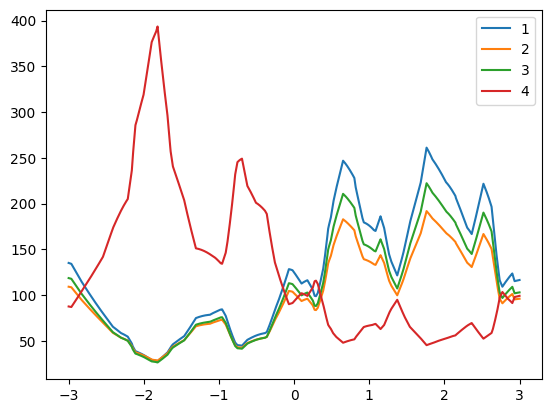

In [4]:
mu_, var_ = m.predict_y(x_grid)
plt.plot(x_grid, mu_, label=[1,2,3,4])
plt.legend()

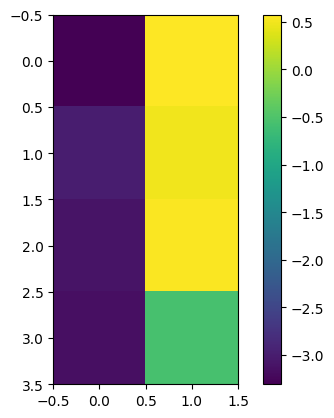

In [5]:
# What does the mixing matrix look like?
plt.imshow(m.kernel.W)
plt.colorbar()
plt.show()

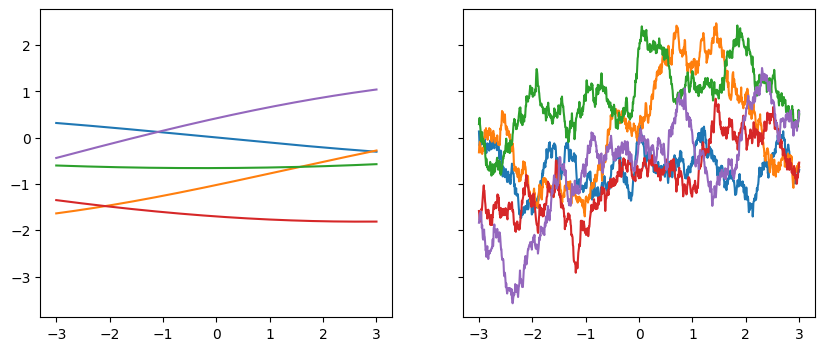

In [6]:
# Inference in latent space
np.random.seed(9102)
lrv1 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=m.kernel.latent_kernels[0].K(x_grid),
    size=5
).T

lrv2 = np.random.multivariate_normal(
    mean=np.zeros_like(x_grid.flatten()),
    cov=m.kernel.latent_kernels[1].K(x_grid),
    size=5
).T

figs, axs = plt.subplots(1, 2, sharey=True, figsize=(10,4))
axs[0].plot(x_grid, lrv1)
axs[1].plot(x_grid, lrv2)
plt.show()

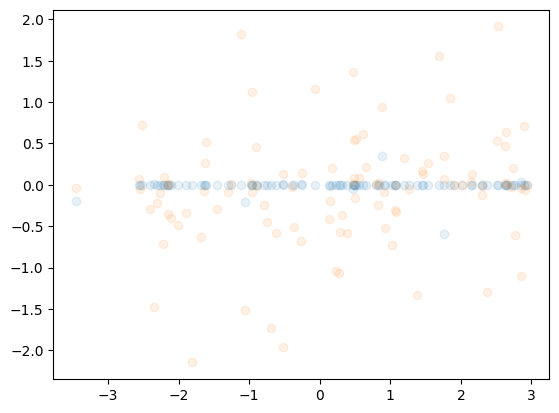

In [7]:
# What do the latent points look like?
plt.plot(m.inducing_variable.inducing_variable_list[0].Z.numpy(), m.q_mu.numpy(), 'o', alpha=0.1)

In [8]:
mu_hat, var_hat = m.predict_f(x_grid)#, full_output_cov=True)

# Get latent mean
l_mu_hat = mu_hat @ tf.transpose(tf.linalg.pinv(m.kernel.W))

# Center means
l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

# Get latent variances
l_var_hat = tf.transpose(tf.linalg.pinv((m.kernel.W)**2) @ tf.transpose(var_hat))

$V(aX+bY+cZ) = a^2V(X)+b^2V(Y)+c^2V(Z)+2abCov(X,Y)+2acCov(X,Z)+2bcCov(Y,Z)$

$V(aX+bY) = [a^2 b^2] [V(X) V(Y)]^T$

In [9]:
# tf.linalg.pinv((m.kernel.W)**2) @ var_hat[0].numpy().reshape(-1, 1)

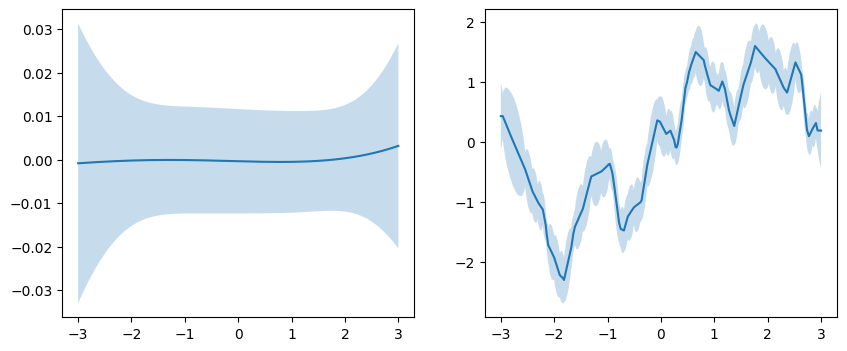

In [10]:
# Now plot latents
figs, axs = plt.subplots(1, 2, figsize=(10,4))
for i in range(2):
    axs[i].fill_between(
        x=x_grid.flatten(), 
        y1=l_mu_hat[:,i] - 1.96*np.sqrt(l_var_hat[:, i]),
        y2=l_mu_hat[:,i] + 1.96*np.sqrt(l_var_hat[:, i]),
        alpha=0.25
    )
    axs[i].plot(x_grid, l_mu_hat[:,i])


# Automated kernel selection

In [ ]:
# def freeze_variance_parameters(kernel):
#     if hasattr(kernel, "variance"):
#         gpflow.utilities.set_trainable(kernel.variance, False)
#         return None
#     elif kernel.name in ["sum", "linear_coregionalization"]:
#         for k in kernel.kernels:
#             # print(f"working on kernel {k}")
#             freeze_variance_parameters(k)
#     elif kernel.name == "periodic":
#         freeze_variance_parameters(kernel.base_kernel)

# # freeze_variance_parameters(m_penalized.kernel)

In [ ]:
from waveome import kernels
num_gps = 3
# ll, blam, bgam, mlist 
cv_out = regularization.lam_search(
    kernel=gpflow.kernels.LinearCoregionalization(
        kernels=[
            gpflow.kernels.SquaredExponential(), 
            gpflow.kernels.Matern12(),
            kernels.Lin(active_dims=[0])
            ],
        W=np.ones(shape=(np.shape(Y)[1], num_gps))
    ),
    X=X,
    Y=Y,
    lam_list=[0., 0.5, 1.],
    freeze_inducing=True,
    freeze_variances=True,
    # max_jobs=12,
    random_seed=9102,
    early_stopping=False,
    max_iter=500000
    # verbose=True,
    # return_all=True
)

lambda value = 0.0, gamma value = 0.0


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are use

ll = -32.138997354380976, se = 5.041812332844328
lambda value = 0.5, gamma value = 0.0
ll = -26.079898613110355, se = 0.5581365241347273
lambda value = 1.0, gamma value = 0.0


In [ ]:
gpflow.utilities.parameter_dict(m)[".kernel.kernels[0].variance"].prior

In [ ]:
# for k, v in gpflow.utilities.parameter_dict(m).items():
#     print(f"Key = {k}, value = {v}")

In [ ]:
print(f"Lambda: {cv_out['best_lambda']}")
cv_out["final_model"]

Lambda: 0.5


name,class,transform,prior,trainable,shape,dtype,value
SVPGPR.kernel.kernels[0].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[0].lengthscales,Parameter,Softplus,Uniform,True,(),float64,9.15651
SVPGPR.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.kernels[1].lengthscales,Parameter,Softplus,Uniform,True,(),float64,0.17801
SVPGPR.kernel.kernels[2].variance,Parameter,Softplus,,False,(),float64,1.0
SVPGPR.kernel.W,Parameter,Identity,,True,"(4, 3)",float64,"[[3.83079, -0.00915, -1.63764..."
SVPGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,640.84553
SVPGPR.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,False,"(100, 1)",float64,[[-1.81682...
SVPGPR.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,False,"(100, 1)",float64,[[0.60961...
SVPGPR.inducing_variable.inducing_variable_list[2].Z,Parameter,Identity,,False,"(100, 1)",float64,[[0.12913...


In [ ]:
# from waveome import kernels
# num_gps = 3

# for l in [0, 0.1, 1, 10, 100, 1000]:
#     m_penalized = regularization.SVPGPR(
#         kernel=gpflow.kernels.LinearCoregionalization(
#             kernels=[
#                 gpflow.kernels.SquaredExponential(), 
#                 gpflow.kernels.Matern12(),
#                 kernels.Lin(active_dims=[0])
#                 ],
#             W=np.random.normal(size=(np.shape(Y)[1], num_gps))
#         ),
#         likelihood=gpflow.likelihoods.Gamma(),
#         inducing_variable=gpflow.inducing_variables.SeparateIndependentInducingVariables(
#             [gpflow.inducing_variables.InducingPoints(X_) for X_ in [X.copy() for _ in range(num_gps)]]
#         ),
#         num_latent_gps=num_gps,
#         X=X[:80, :],
#         Y=Y[:80,:],
#         lam=l #100000000000000000000
#     )

#     # Freeze kernel variance parameters
#     utilities.freeze_variance_parameters(m_penalized.kernel)

#     # Freeze inducing variables
#     gpflow.utilities.set_trainable(m_penalized.inducing_variable.inducing_variables, False)

#     # Set prior on W matrix
#     # m_penalized.kernel.W.prior = tfp.distributions.Exponential(f64(1))

#     # Optimize hyperparameters
#     opt_res = gpflow.optimizers.Scipy().minimize(
#         m_penalized.training_loss_closure((X[:80,:], Y[:80,:])),
#         m_penalized.trainable_variables,
#         options={"maxiter": 20000}
#     )

#     print(f"Holdout LogLik: {tf.reduce_sum(m_penalized.predict_log_density((X[80:,:],Y[80:,:])))}")
#     print(l)
#     print(np.abs(m_penalized.kernel.W.numpy()).sum())
#     print(m_penalized.kernel.W)

# # print(opt_res)

# # gpflow.utilities.print_summary(m_penalized)

In [ ]:
# m_penalized = regularization.SVPGPR(
#     kernel=gpflow.kernels.LinearCoregionalization(
#         kernels=[
#             gpflow.kernels.SquaredExponential(), 
#             gpflow.kernels.Matern12(),
#             kernels.Lin(active_dims=[0])
#             ],
#     W=np.random.normal(size=(np.shape(Y)[1], num_gps))
#     ),
#     likelihood=gpflow.likelihoods.Gamma(),
#     inducing_variable=gpflow.inducing_variables.SeparateIndependentInducingVariables(
#         [gpflow.inducing_variables.InducingPoints(X_) for X_ in [X.copy() for _ in range(num_gps)]]
#     ),
#     num_latent_gps=num_gps,
#     X=X,
#     Y=Y,
#     lam=blam
# )

# # Freeze kernel variance parameters
# utilities.freeze_variance_parameters(m_penalized.kernel)

# # Freeze inducing variables
# gpflow.utilities.set_trainable(m_penalized.inducing_variable.inducing_variables, False)

# # Set prior on W matrix
# # m_penalized.kernel.W.prior = tfp.distributions.Exponential(f64(1))

# # Optimize hyperparameters
# opt_res = gpflow.optimizers.Scipy().minimize(
#     m_penalized.training_loss_closure((X, Y)),
#     m_penalized.trainable_variables,
#     options={"maxiter": 20000}
# )

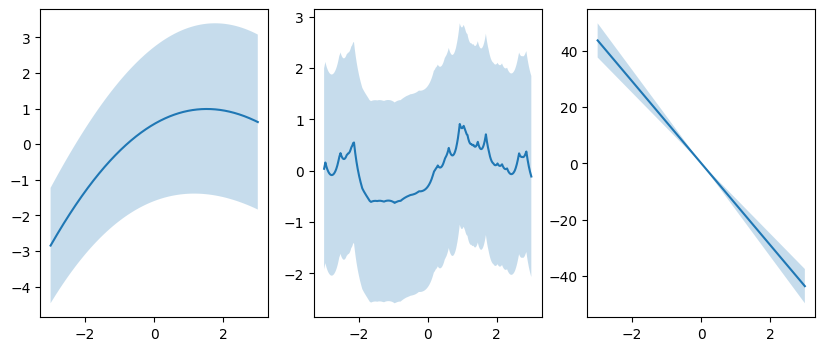

In [ ]:
mu_hat, var_hat = cv_out["final_model"].predict_f(x_grid)#, full_output_cov=True)

# Get latent mean
l_mu_hat = mu_hat @ tf.transpose(tf.linalg.pinv(cv_out["final_model"].kernel.W))

# Center means
l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

# Get latent variances
l_var_hat = tf.transpose(tf.linalg.pinv((cv_out["final_model"].kernel.W)**2) @ tf.transpose(var_hat))

# Now plot latents
figs, axs = plt.subplots(1, num_gps, figsize=(10,4))
for i in range(num_gps):
    axs[i].fill_between(
        x=x_grid.flatten(), 
        y1=l_mu_hat[:,i] - 1.96*np.sqrt(l_var_hat[:, i]),
        y2=l_mu_hat[:,i] + 1.96*np.sqrt(l_var_hat[:, i]),
        alpha=0.25
    )
    axs[i].plot(x_grid, l_mu_hat[:,i])


## Now add multiple units

In [2]:
k1_ind = gpflow.kernels.SquaredExponential(active_dims=[1])
k2_ind = kernels.Categorical(active_dims=[0]) * gpflow.kernels.Matern12(variance=1., lengthscales=0.5, active_dims=[1])

x_grid = np.linspace(start=-3, stop=3, num=50).reshape(-1, 1)
w_matrix = np.array([[0.9, 0.1],[0.1, 0.9],[.5, .5], [-.5, -.5]])
ids = np.arange(start=1, stop=6)
id_grid = np.repeat(ids, len(x_grid)).reshape(-1, 1)
multi_x_grid = np.tile(x_grid.flatten(), len(ids)).reshape(-1, 1)
multi_x_grid = np.hstack((id_grid, multi_x_grid))

In [3]:
np.random.seed(9102)

# Seasonality component shared across individuals
# lrv1_multi = np.sin(multi_x_grid[:, 1]).reshape(-1, 1)
lrv1_multi = np.random.multivariate_normal(
    mean=np.zeros_like(id_grid.flatten()),
    cov=k1_ind(multi_x_grid),
    size=1
).T

# Individual component
lrv2_multi = np.random.multivariate_normal(
    mean=np.zeros_like(id_grid.flatten()),
    cov=k2_ind(multi_x_grid),
    size=1
).T

multi_mu = (w_matrix @ np.concatenate((lrv1_multi, lrv2_multi), axis=1).T).T
multi_y = np.random.gamma(shape=100., scale=np.exp(multi_mu))

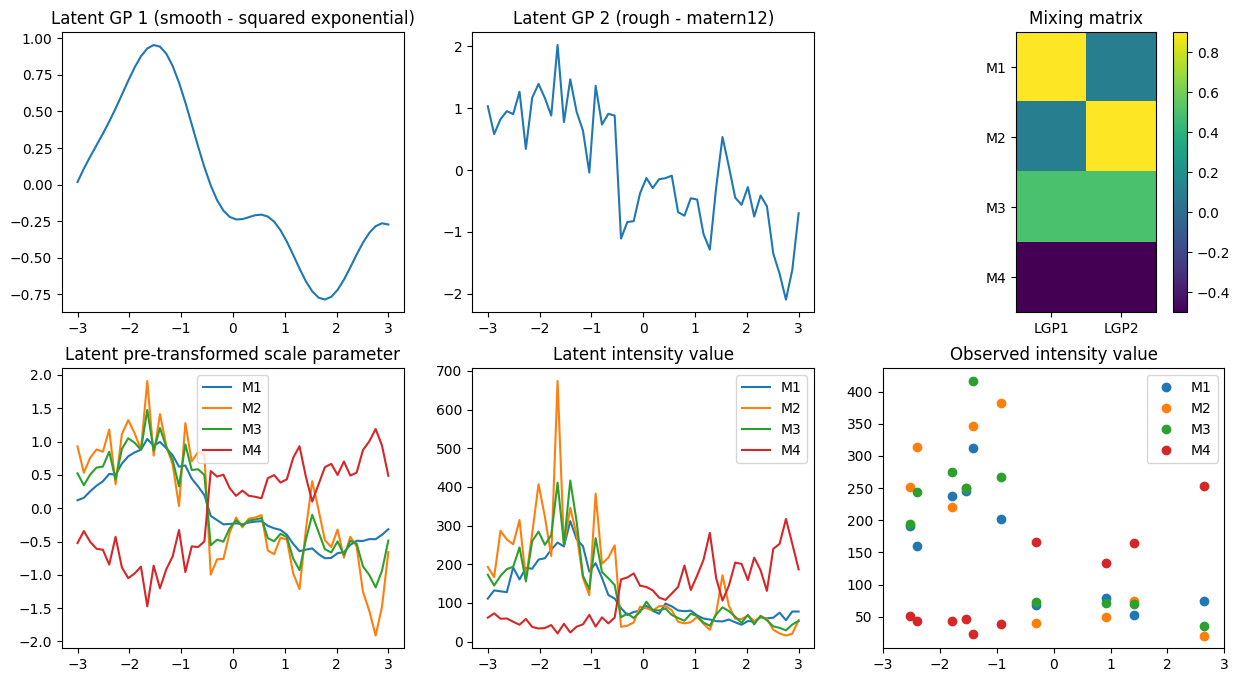

In [42]:
n_obs=10
figs, axs = plt.subplots(2, 3, figsize=(15, 8))
axs[0, 0].plot(multi_x_grid[:50, 1], lrv1_multi[:50])
axs[0, 0].set_title("Latent GP 1 (smooth - squared exponential)")
axs[0, 1].plot(multi_x_grid[:50, 1], lrv2_multi[:50])
axs[0, 1].set_title("Latent GP 2 (rough - matern12)")
axs[0, 2].imshow(w_matrix)
axs[0, 2].set_title("Mixing matrix")
axs[0, 2].set_yticks([0, 1, 2, 3])
axs[0, 2].set_yticklabels(["M1", "M2", "M3", "M4"])
axs[0, 2].set_xticks([0, 1])
axs[0, 2].set_xticklabels(["LGP1", "LGP2"])
plt.colorbar(axs[0, 2].imshow(w_matrix), ax=axs[0, 2])

# Now plot the combined GPs
axs[1, 0].plot(multi_x_grid[:50, 1], multi_mu[:50,:], label=["M1", "M2", "M3", "M4"])
axs[1, 0].set_title("Latent pre-transformed scale parameter")
axs[1, 0].legend()
# obs_out = np.random.gamma(shape=100., scale=np.exp(y_out))
axs[1, 1].plot(x_grid, multi_y[:50, :], label=["M1", "M2", "M3", "M4"])
axs[1, 1].set_title("Latent intensity value")
axs[1, 1].legend()

# Subset observations
sub_idx = np.random.choice(a=range(len(multi_x_grid[:50,1])), size=n_obs, replace=False)
axs[1, 2].plot(multi_x_grid[:50,:][sub_idx,1], 
               multi_y[:50,:][sub_idx,:], 
               'o', label=["M1", "M2", "M3", "M4"])
axs[1, 2].set_xlim((-3, 3))
axs[1, 2].legend()
axs[1, 2].set_title("Observed intensity value")
plt.show()

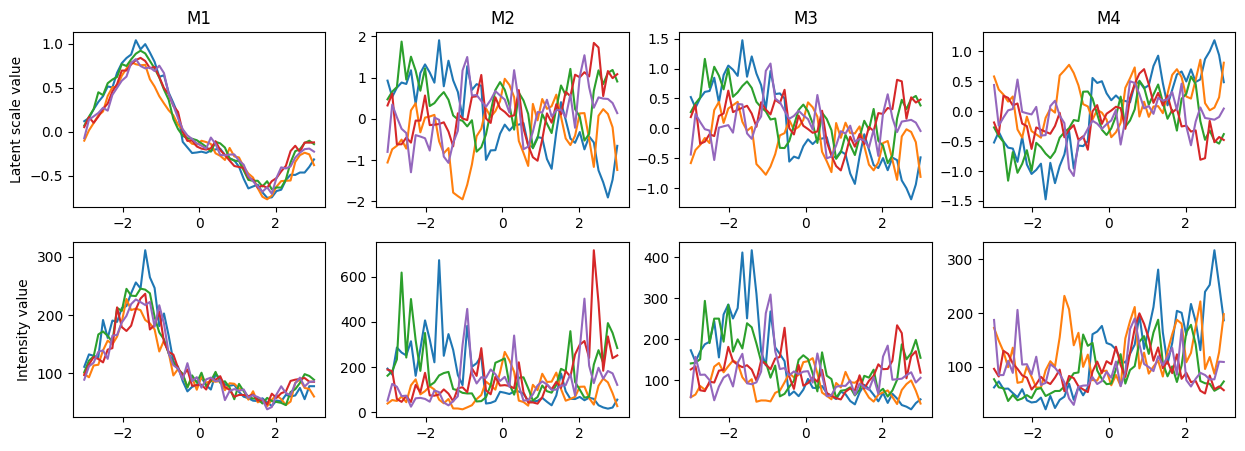

In [92]:
figs, axs = plt.subplots(2, 4, figsize=(15, 5))
row_c = 0
# for y_ in range(multi_y.shape[1]):
#     print(f"y_: {y_}, row_c: {row_c}")
#     for i in np.unique(id_grid):
#         axs[row_c % 2, y_ % 2].plot(multi_x_grid[multi_x_grid[:,0] == i, 1], multi_y[multi_x_grid[:, 0] == i, y_])
#     if y_ == 1:
#         row_c += 1
for y_ in range(multi_y.shape[1]):
    for i in np.unique(id_grid):
        axs[0, y_].plot(multi_x_grid[multi_x_grid[:,0] == i, 1], multi_mu[multi_x_grid[:, 0] == i, y_])
for y_ in range(multi_y.shape[1]):
    for i in np.unique(id_grid):
        axs[1, y_].plot(multi_x_grid[multi_x_grid[:,0] == i, 1], multi_y[multi_x_grid[:, 0] == i, y_])

axs[0, 0].set_ylabel("Latent scale value")
axs[1, 0].set_ylabel("Intensity value")
axs[0, 0].set_title("M1")
axs[0, 1].set_title("M2")
axs[0, 2].set_title("M3")
axs[0, 3].set_title("M4")
plt.show()

In [21]:
# # Now make the observed dataset
# k1_ind = gpflow.kernels.SquaredExponential(active_dims=[1])
# k2_ind = kernels.Categorical(active_dims=[0]) * gpflow.kernels.Matern12(variance=1., lengthscales=0.5, active_dims=[1])

# np.random.seed(9102)
# ids = np.arange(start=1, stop=101)
# # Get midpoint for each individual
# id_mid = np.random.uniform(low=-3, high=3, size=len(ids))
# # Now get points around each individuals midpoint
# num_obs_per_id = 10
# x_grid = np.concatenate([np.random.normal(loc=x, scale=1., size=num_obs_per_id) for x in id_mid]).reshape(-1, 1)
# id_grid = np.repeat(ids, num_obs_per_id).reshape(-1, 1)
# # multi_x_grid = np.tile(x_grid.flatten(), len(ids)).reshape(-1, 1)
# multi_x_grid = np.hstack((id_grid, x_grid))

# # Seasonality component shared across individuals
# # lrv1_multi = np.sin(multi_x_grid[:, 1]).reshape(-1, 1)
# lrv1_multi = np.random.multivariate_normal(
#     mean=np.zeros_like(id_grid.flatten()),
#     cov=k1_ind(multi_x_grid),
#     size=1
# ).T

# # Individual component
# lrv2_multi = np.random.multivariate_normal(
#     mean=np.zeros_like(id_grid.flatten()),
#     cov=k2_ind(multi_x_grid),
#     size=1
# ).T

# multi_y = (w_matrix @ np.concatenate((lrv1_multi, lrv2_multi), axis=1).T).T

# # Pass through likelihood now
# multi_y = np.random.gamma(shape=100., scale=np.exp(multi_y))
# multi_y.shape

(1000, 4)

In [27]:
num_gps = 5#7

# Now try to standardize to nullify the shape parameter
# MOM: k = E[X]^2/V[X]
k_hat = (multi_y.mean(axis=0))**2/multi_y.var(axis=0)
multi_y_new = multi_y/k_hat

# ll, blam, bgam, mlist 
cv_out_multi = regularization.lam_search(
    kernel=gpflow.kernels.LinearCoregionalization(
        kernels=[
            kernels.Categorical(active_dims=[0]),
            gpflow.kernels.SquaredExponential(active_dims=[1]), 
            gpflow.kernels.Matern12(active_dims=[1]),
            # kernels.Lin(active_dims=[1]),
            kernels.Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[1]), 
            kernels.Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[1]),
            # kernels.Categorical(active_dims=[0])*kernels.Lin(active_dims=[1])
            ],
        W=np.ones(shape=(np.shape(multi_y)[1], num_gps))
    ),
    X=multi_x_grid,
    Y=multi_y_new, #multi_y/multi_y.var(axis=0), #multi_y,
    lam_list=np.arange(start=0, stop=1.1, step=0.05), #[0., 0.25, 0.5, 0.75, 1.],
    freeze_inducing=True,
    num_inducing_points=100,
    k_fold=5,
    freeze_variances=True,
    random_seed=9102,
    # early_stopping=False,
    verbose=True,
    unit_col=0,
    likelihood=gpflow.likelihoods.Gamma(),
    max_iter=10000
)

lambda value = 0.0, gamma value = 0.0


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are use

New best log likelihood: -3003.2877490200885
New best log likelihood: -2967.044861458916
New best log likelihood: -3030.7098143799144
New best log likelihood: -2968.89339533716
New best log likelihood: -2933.8428631274023
New best log likelihood: -2958.676670228548
New best log likelihood: -2965.319652977301
New best log likelihood: -2953.3676904058825
New best log likelihood: -2891.579556687255
New best log likelihood: -2935.4713367354775
Model: [], BIC: 5894.94
New best log likelihood: -2907.3778324884115
New best log likelihood: -2954.535769961198
Model: [], BIC: 5933.07
New best log likelihood: -2893.3852232857826
Model: [], BIC: 5807.16
Model: [], BIC: 5810.77
Model: [], BIC: 5930.74
ll = -17.038391709973418, se = 0.44011544231088273
lambda value = 0.05, gamma value = 0.0
New best log likelihood: -2960.4116453232546
New best log likelihood: -2993.9114714297125
New best log likelihood: -2956.526583882858
New best log likelihood: -2939.135389597791
New best log likelihood: -2973.802

In [28]:
cv_out_multi

{'cv_log_lik': {0.0: {0.0: [-16.53223323667111,
    -15.706973855074029,
    -17.719496677679015,
    -16.699825018192765,
    -18.533429762250165]},
  0.05: {0.0: [-16.720720834281472,
    -16.030929123429544,
    -19.36646075036042,
    -15.596566384133434,
    -18.811230773336828]},
  0.1: {0.0: [-17.242101301881846,
    -18.37901789800281,
    -16.49832186927798,
    -17.050257862701798,
    -20.39117131002318]},
  0.15000000000000002: {0.0: []},
  0.2: {0.0: []},
  0.25: {0.0: []},
  0.30000000000000004: {0.0: []},
  0.35000000000000003: {0.0: []},
  0.4: {0.0: []},
  0.45: {0.0: []},
  0.5: {0.0: []},
  0.55: {0.0: []},
  0.6000000000000001: {0.0: []},
  0.65: {0.0: []},
  0.7000000000000001: {0.0: []},
  0.75: {0.0: []},
  0.8: {0.0: []},
  0.8500000000000001: {0.0: []},
  0.9: {0.0: []},
  0.9500000000000001: {0.0: []},
  1.0: {0.0: []},
  1.05: {0.0: []}},
 'best_lambda': 0.0,
 'best_gamma': 0.0,
 'final_model': <waveome.regularization.SVPGPR object at 0x2cbb9bbb0>
╒══════════

In [29]:
cv_out_multi["final_model"].kernel.kernels[4].name

'product'

In [54]:
# num_gps = 7
# m_foo, bic_foo = regularization.kernel_test_reg(
#     k=gpflow.kernels.LinearCoregionalization(
#         kernels=[
#             kernels.Categorical(active_dims=[0]),
#             gpflow.kernels.SquaredExponential(active_dims=[1]), 
#             gpflow.kernels.Matern12(active_dims=[1]),
#             kernels.Lin(active_dims=[1]),
#             kernels.Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[1]), 
#             kernels.Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[1]),
#             kernels.Categorical(active_dims=[0])*kernels.Lin(active_dims=[1])
#             ],
#         W=np.ones(shape=(np.shape(multi_y)[1], num_gps))
#     ),
#     X=multi_x_grid[:50, :],
#     Y=multi_y[:50,:],
#     lam=1,#, 0.25, 0.5, 0.75, 1.],
#     freeze_inducing=True,
#     # num_inducing_points=200,
#     freeze_variances=True,
#     random_seed=9102,
#     # early_stopping=False,
#     verbose=True,
#     lasso=True,
#     random_init=True,
#     likelihood=gpflow.likelihoods.Gamma(shape=np.ones(shape=4))
# ) # 13m 3.3s 10,000 max iter, # 9m 15s 5,000 max iter, # 4m 2.1s if freeze_inducing is True

In [30]:
cv_out_multi["final_model"].kernel.W

<Parameter: name=identity, dtype=float64, shape=[4, 5], fn="identity", numpy=
array([[ 4.10001599e-01,  4.24882006e-01, -1.56428416e-02,
         9.54178377e-03, -1.08104769e-04],
       [ 1.42922529e+00, -1.09109856e-01, -1.10746975e-01,
         9.00702000e-02, -1.32543516e-04],
       [ 5.25434453e-01,  1.61678593e-01, -5.92416230e-02,
         5.12846762e-02, -5.40191770e-05],
       [ 3.41025313e-01, -1.70789072e-01,  5.70974629e-02,
        -5.06187530e-02, -3.48940623e-05]])>

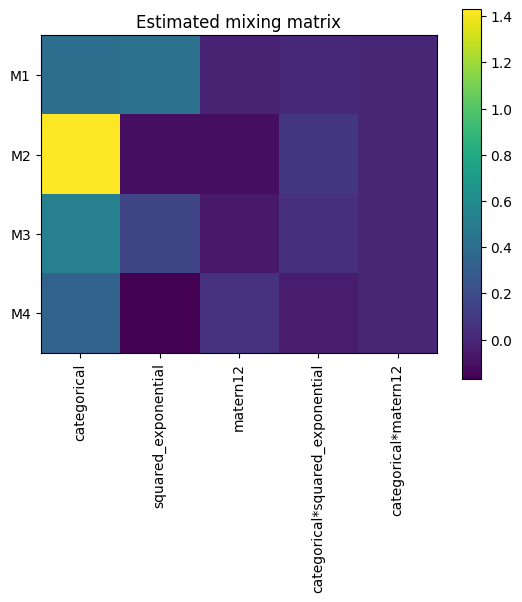

In [32]:
plt.imshow(cv_out_multi["final_model"].kernel.W)
plt.colorbar()
plt.title("Estimated mixing matrix")
plt.yticks(
    ticks=[0, 1, 2, 3],
    labels=["M1", "M2", "M3", "M4"]
)
plt.xticks(
    ticks=[0, 1, 2, 3, 4],
    labels=[
        "categorical", "squared_exponential", "matern12", #"linear",
        "categorical*squared_exponential", "categorical*matern12", 
        # "categorical*linear"
    ],
    rotation=90
)
plt.show()

In [33]:
W_norm

array([[0.5 , 0.46, 0.  , 0.  , 0.02, 0.  , 0.02],
       [0.81, 0.02, 0.  , 0.  , 0.08, 0.01, 0.07],
       [0.66, 0.22, 0.  , 0.  , 0.1 , 0.01, 0.01],
       [0.51, 0.24, 0.  , 0.  , 0.11, 0.01, 0.14]])

MSE of Y: 12437.76686493185
['categorical' 'squared_exponential' 'matern12'
 'categorical*squared_exponential']
MSE of W: 0.22242129156276289
MSE LV1: 1.4469394849604598, MSE LV2: 0.6895457144744948


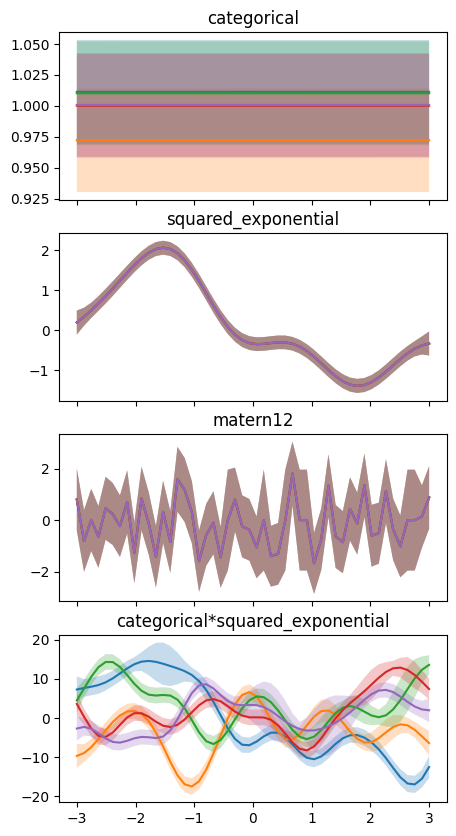

In [45]:
multi_x_grid_sorted = multi_x_grid[np.argsort(multi_x_grid[:, 1])]

mu_hat, var_hat = cv_out_multi["final_model"].predict_f(multi_x_grid_sorted)#, full_output_cov=True)
y_hat, y_var_hat = cv_out_multi["final_model"].predict_y(multi_x_grid_sorted)

mse_y = ((multi_y - y_hat.numpy())**2).mean()
print(f"MSE of Y: {mse_y}")

# "On" processes
W_ = cv_out_multi["final_model"].kernel.W.numpy()
W_norm = (np.abs(W_)/np.abs(W_).sum(axis=1)[:, None]).round(2)
keep_gps = W_norm.mean(axis=0) > 0.01
kernel_list = [
    "categorical", "squared_exponential", "matern12", #"linear",
    "categorical*squared_exponential", "categorical*matern12"#, "categorical*linear"
]
print(np.array(kernel_list)[keep_gps])

# Get Mean Absolute Error
w_true = np.array(
    [[0., 0.9, 0., 0., 0.1],
     [0., 0.1, 0., 0., 0.9],
     [0., 0.5, 0., 0., 0.5],
     [0., -0.5, 0., 0., -0.5]]
)

mse_w = ((w_true - W_ )**2).mean()
print(f"MSE of W: {mse_w}")

# Get latent mean
l_mu_hat = mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_))[:, keep_gps]

# Center means
# l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

# Get latent variances
l_var_hat = np.transpose(np.linalg.pinv((W_[:, keep_gps])**2) @ np.transpose(var_hat))

# Get MSE for each true latent function
mse_lv1 = ((lrv1_multi - (mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_))[:, 1]))**2).mean() 
mse_lv2 = ((lrv2_multi - (mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_))[:, 4]))**2).mean()
print(f"MSE LV1: {mse_lv1}, MSE LV2: {mse_lv2}")

# Now plot latents
figs, axs = plt.subplots(sum(keep_gps), 1, figsize=(5,10), sharex=True)
for i in range(sum(keep_gps)):
    for idx in np.unique(multi_x_grid_sorted[:, 0]):
        axs[i].fill_between(
            x=multi_x_grid_sorted[multi_x_grid_sorted[:, 0] == idx, 1].flatten(), 
            y1=l_mu_hat[multi_x_grid_sorted[:, 0] == idx,i] - 1.96*np.sqrt(l_var_hat[multi_x_grid_sorted[:, 0] == idx, i]),
            y2=l_mu_hat[multi_x_grid_sorted[:, 0] == idx,i] + 1.96*np.sqrt(l_var_hat[multi_x_grid_sorted[:, 0] == idx, i]),
            alpha=0.25
        )
        axs[i].plot(multi_x_grid_sorted[multi_x_grid_sorted[:, 0] == idx, 1], l_mu_hat[multi_x_grid_sorted[:, 0] == idx,i])

    axs[i].set_title(np.array(kernel_list)[keep_gps][i])


## Full simulation set up

In [46]:
def generate_sim_data(num_ids, num_obs_per_id, random_seed):
    # Now make the observed dataset
    k1_ind = gpflow.kernels.SquaredExponential(active_dims=[1])
    k2_ind = kernels.Categorical(active_dims=[0]) * gpflow.kernels.Matern12(variance=1., lengthscales=0.5, active_dims=[1])

    np.random.seed(random_seed)
    w_matrix = np.array([[0.9, 0.1],[0.1, 0.9],[.5, .5], [-.5, -.5]])
    ids = np.arange(start=0, stop=num_ids)
    # Get midpoint for each individual
    id_mid = np.random.uniform(low=-3, high=3, size=len(ids))
    # Now get points around each individuals midpoint
    # num_obs_per_id = 
    x_grid = np.concatenate([np.random.normal(loc=x, scale=1., size=num_obs_per_id) for x in id_mid]).reshape(-1, 1)
    id_grid = np.repeat(ids, num_obs_per_id).reshape(-1, 1)
    # multi_x_grid = np.tile(x_grid.flatten(), len(ids)).reshape(-1, 1)
    multi_x_grid = np.hstack((id_grid, x_grid))

    # Seasonality component shared across individuals
    # lrv1_multi = np.sin(multi_x_grid[:, 1]).reshape(-1, 1)
    lrv1_multi = np.random.multivariate_normal(
        mean=np.zeros_like(id_grid.flatten()),
        cov=k1_ind(multi_x_grid),
        size=1
    ).T

    # Individual component
    lrv2_multi = np.random.multivariate_normal(
        mean=np.zeros_like(id_grid.flatten()),
        cov=k2_ind(multi_x_grid),
        size=1
    ).T

    multi_y = (w_matrix @ np.concatenate((lrv1_multi, lrv2_multi), axis=1).T).T

    # Pass through likelihood now
    multi_y = np.random.gamma(shape=100., scale=np.exp(multi_y))
    return multi_x_grid, multi_y, lrv1_multi, lrv2_multi

def build_model(multi_x_grid, multi_y):
    num_gps = 5
    # ll, blam, bgam, mlist 
    k_hat = (multi_y.mean(axis=0))**2/multi_y.var(axis=0)
    multi_y_new = multi_y/k_hat

    cv_out_multi = regularization.lam_search(
        kernel=gpflow.kernels.LinearCoregionalization(
            kernels=[
                kernels.Categorical(active_dims=[0]),
                gpflow.kernels.SquaredExponential(active_dims=[1]), 
                gpflow.kernels.Matern12(active_dims=[1]),
                # kernels.Lin(active_dims=[1]),
                kernels.Categorical(active_dims=[0])*gpflow.kernels.SquaredExponential(active_dims=[1]), 
                kernels.Categorical(active_dims=[0])*gpflow.kernels.Matern12(active_dims=[1]),
                # kernels.Categorical(active_dims=[0])*kernels.Lin(active_dims=[1])
                ],
            W=np.ones(shape=(np.shape(multi_y)[1], num_gps))
        ),
        X=multi_x_grid,
        Y=multi_y_new,
        lam_list=np.arange(start=0, stop=1.1, step=0.05), #[0., 0.25, 0.5, 0.75, 1.],
        # freeze_inducing=True,
        num_inducing_points=100,
        k_fold=5,
        freeze_variances=True,
        random_seed=9102,
        # early_stopping=False,
        # verbose=True,
        max_jobs=1,
        unit_col=0,
        likelihood=gpflow.likelihoods.Gamma(),
        max_iter=10000
    )

    return cv_out_multi

def evaluate_fit(multi_x_grid, multi_y, cv_out_multi, lrv1_multi, lrv2_multi):
    mu_hat, var_hat = cv_out_multi["final_model"].predict_f(multi_x_grid)
    y_hat, y_var_hat = cv_out_multi["final_model"].predict_y(multi_x_grid)

    mse_y = ((multi_y - y_hat.numpy())**2).mean()
    # print(f"MSE of Y: {mse_y}")

    # "On" processes
    W_ = cv_out_multi["final_model"].kernel.W.numpy()
    W_norm = (np.abs(W_)/np.abs(W_).sum(axis=1)[:, None]).round(2)
    keep_gps = W_norm.mean(axis=0) > 0.01
    kernel_list = [
        "categorical", "squared_exponential", "matern12", #"linear",
        "categorical*squared_exponential", "categorical*matern12"#, "categorical*linear"
    ]
    # print(np.array(kernel_list)[keep_gps])
    kernel_selection = np.array(kernel_list)[keep_gps]

    # Get Mean Absolute Error
    w_true = np.array(
        [[0., 0.9, 0., 0., 0.1],
        [0., 0.1, 0., 0., 0.9],
        [0., 0.5, 0., 0., 0.5],
        [0., -0.5, 0., 0., -0.5]]
    )

    mse_w = ((w_true - W_ )**2).mean()
    # print(f"MSE of W: {mse_w}")

    # Get latent mean
    # l_mu_hat = mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_[:, keep_gps]))

    # # Center means
    # # l_mu_hat = l_mu_hat - tf.math.reduce_mean(l_mu_hat, axis=0)

    # # Get latent variances
    # l_var_hat = np.transpose(np.linalg.pinv((W_[:, keep_gps])**2) @ np.transpose(var_hat))

    # Get MSE for each true latent function
    mse_lv1 = ((lrv1_multi - (mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_))[:, 1]))**2).mean() 
    mse_lv2 = ((lrv2_multi - (mu_hat.numpy() @ np.transpose(np.linalg.pinv(W_))[:, 4]))**2).mean()
    # print(f"MSE LV1: {mse_lv1}, MSE LV2: {mse_lv2}")

    return mse_y, mse_w, mse_lv1, mse_lv2, kernel_selection

def run_sim(num_ids, num_obs_per_id, random_seed):
    x, y, lrv1, lrv2 = generate_sim_data(num_ids, num_obs_per_id, random_seed)
    cv_out = build_model(x, y)
    eval_list = evaluate_fit(x, y, cv_out, lrv1, lrv2)
    return eval_list

In [47]:
run_sim(num_ids=5, num_obs_per_id=5, random_seed=1)

KeyboardInterrupt: 

In [53]:
sim_ops = np.repeat(
    np.array([[(ni, no) for ni in [10, 50, 100]] for no in [5, 10, 50]]).reshape(-1, 2),
    50,
    axis=0
)

sim_ops.shape

(450, 2)

In [58]:
from joblib import Parallel, delayed
from tqdm import tqdm
from waveome.model_search import tqdm_joblib

sim_ops = np.repeat(
    np.array([[(ni, no) for ni in [10, 50, 100]] for no in [5, 10, 20]]).reshape(-1, 2),
    10,
    axis=0
)

with tqdm_joblib(tqdm(desc="simulation", total=sim_ops.shape[0])) as p_bar:
    par_res = Parallel(n_jobs=14)(delayed(run_sim)(
        num_ids=sim_ops[i, 0],
        num_obs_per_id=sim_ops[i, 1],
        random_seed=i
    ) for i in range(sim_ops.shape[0]))

simulation:   0%|          | 0/90 [00:00<?, ?it/s]WARNING:tensorflow:From /Users/allen/miniforge3/envs/waveome/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:561: calling function (from tensorflow.python.eager.polymorphic_function.polymorphic_function) with experimental_relax_shapes is deprecated and will be removed in a future version.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
Instructions for updating:
experimental_relax_shapes is depr

In [72]:
import pandas as pd
sim_df = (
    pd.DataFrame(
        par_res, 
        columns=["MSE_Y", "MSE_W", "MSE_LV1", "MSE_LV2", "kernels"]
    ).assign(
        flag = lambda x: [["categorical*matern12" == y or "squared_exponential" == y for y in x_] for x_ in x.kernels],
        ni = sim_ops[:, 0],
        no = sim_ops[:, 1]
    )
)
sim_df["flag"] = [sum(x)==2 for x in sim_df["flag"]]
sim_df.head()

,MSE_Y,MSE_W,MSE_LV1,MSE_LV2,kernels,flag,ni,no
0,17950.672390,1.002713,0.567516,0.966828,"[categorical, squared_exponential, matern12, c...",True,10,5
1,19532.004449,1.002713,0.675734,0.849125,"[categorical, squared_exponential, matern12, c...",True,10,5
2,29593.604738,1.002713,0.230737,1.104238,"[categorical, squared_exponential, matern12, c...",True,10,5
3,33654.916640,1.002713,1.596436,0.546570,"[categorical, squared_exponential, matern12, c...",True,10,5
4,41176.722187,1.002713,1.210530,0.910067,"[categorical, squared_exponential, matern12, c...",True,10,5


In [82]:
sim_df_long = pd.melt(
    frame=sim_df,
    id_vars=["ni", "no"],
    value_vars=["MSE_Y", "MSE_W", "MSE_LV1", "MSE_LV2"],
    value_name="Mean Squared Error",
    var_name="Metric"
)
sim_df_long.head()

,ni,no,Metric,Mean Squared Error
0,10,5,MSE_Y,17950.672390
1,10,5,MSE_Y,19532.004449
2,10,5,MSE_Y,29593.604738
3,10,5,MSE_Y,33654.916640
4,10,5,MSE_Y,41176.722187


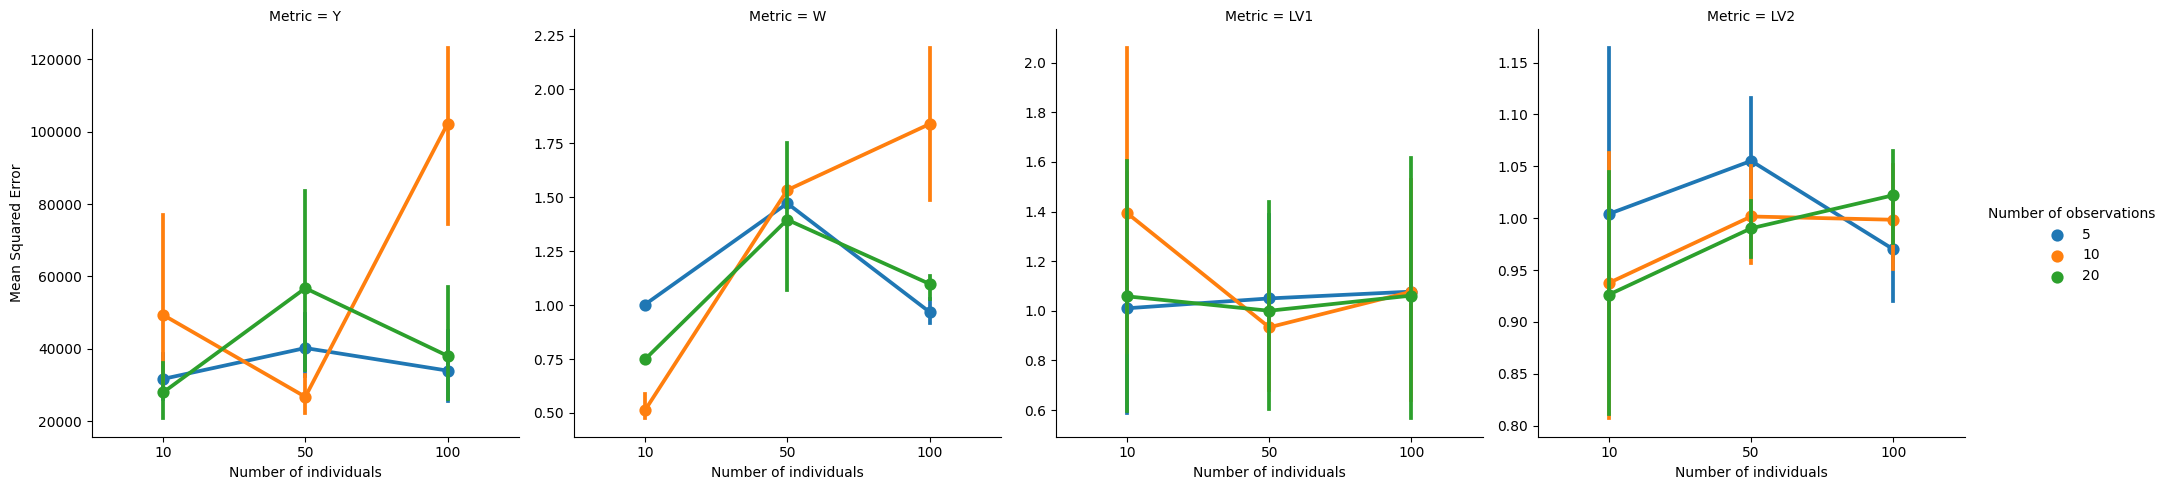

In [83]:
import seaborn as sns
sns.catplot(
    data=sim_df_long.rename(columns={"ni": "Number of individuals", "no": "Number of observations"}).assign(Metric = sim_df_long.Metric.str.replace("MSE_", "")),
    x="Number of individuals", 
    y="Mean Squared Error", 
    col="Metric",
    hue="Number of observations",
    kind="point",
    sharey=False,
    # errorbar="se"
)